## Medical image denoising using deep convolutional denoising autoencoder
More info about the process and architecture in the paper: https://arxiv.org/pdf/1608.04667.pdf

Data source: https://figshare.com/s/37ec464af8e81ae6ebbf


In [1]:
import numpy as np
import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import pydot as pyd
tensorflow.keras.utils.pydot = pyd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2 as cv
import skimage
import random
import pandas as pd
from IPython.display import SVG
import os
import shutil
import sys
%matplotlib inline

### For more efficient computation according to the paper images should be resized to 64x64 pixels. 

In [2]:
def resize(image, width=None, height=None, inter=cv.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    if width is not None and height is not None:
        dim = (width, height)

    resized = cv.resize(image, dim, interpolation=inter)

    return resized

In [3]:
def apply_resize(img_path):
    
    X_ll = []
    
    for im in os.listdir(img_path):
        
        img = cv.imread(img_path+im)
        
        img_resized = resize(img,width=64, height=64)
        
        X_ll.append(img_resized)
        
        cv.imwrite(img_path+im,img_resized)
        
    X = np.asarray(X_ll)
    
    return X

In [4]:
X_train = apply_resize('RawImage/TrainingData/')

In [5]:
X_test = apply_resize('RawImage/Test1Data/')

In [6]:
X_train.shape

(150, 64, 64, 3)

### In order to speed up the training images are normalized to range [0,1]

In [7]:
def preprocess(x):
    
    x = x.astype('float32') / 255
    
    return x

In [8]:
x_train = preprocess(X_train)

In [9]:
x_test = preprocess(X_test)

In [10]:
def clip_data(x):
    
    x = np.clip(x, 0., 1.)

    x = np.clip(x, 0., 1.)

    return x

### Generates various types of noise based on definition of denoising autoencoder so that learning would become more robust.

In [11]:
def make_poisson_noise(x):
    
    vals = len(np.unique(x))
    
    vals = 2 ** np.ceil(np.log2(vals))
    
    poisson_noise_imgs = np.random.poisson(x * vals) / float(vals)
    
    #poisson_noise_imgs = x + noisy
    
    poisson_noise_imgs = clip_data(poisson_noise_imgs)
    
    return poisson_noise_imgs
    

In [12]:
def make_sp_noise(x,prob):
    '''
    Add salt and pepper noise to image
    
    Arguments: 
    prob -- Probability of the noise
    '''
    output = np.zeros(x.shape,np.uint8)
    thres = 1 - prob 
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            for k in range(x.shape[2]):
                #for l in range(image.shape[3]):
                rdn = random.random()
                if rdn < prob:
                    output[i][j][k] = 0
                elif rdn > thres:
                    output[i][j][k] = 255
                else:
                    output[i][j][k]= x[i][j][k]
    
    sp_noise_imgs = x + output
    
    sp_noise_imgs = clip_data(sp_noise_imgs)
    
    return sp_noise_imgs

In [13]:
def make_gaussian_noise(x, mean, std, alpha, beta, gamma):
    
    '''''
    Generates gaussian noise in original image based on this equation:
    dst = src1*alpha + src2*beta + gamma -> cv.addWeighted(src1, alpha, src2, beta, gamma)
    
    Arguments:
    
    mean -- mean of gaussian distribution
    
    std -- standard deviation of gaussian distribution
    
    alpha -- proportion of noise free pixels
    
    beta -- proportion of noise to add
    
    gamma -- constant
    
    Returns:
    
    Corrupted original image
    '''''
    
    gaussian_noise_imgs = []
    
    row, col, _ = x[0].shape
    
    for x_img in x:
        
        gaussian = np.random.normal(mean, std, (row, col, 1)).astype(np.float32)
        
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        
        gaussian_img = cv.addWeighted(x_img, alpha, beta * gaussian, beta, gamma)
        
        gaussian_noise_imgs.append(gaussian_img)
        
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    
    gaussian_noise_imgs = clip_data(gaussian_noise_imgs)
    
    return gaussian_noise_imgs

In [14]:
mean = 0
std = 1
beta = 0.25
alpha = 1-beta
gamma = 0

x_train_noisy_gauss = make_gaussian_noise(x_train, mean, std, alpha, beta, gamma)
x_test_noisy_gauss = make_gaussian_noise(x_test, mean, std, alpha, beta, gamma)

In [15]:
prob = 0.5

x_train_noisy_sp = make_sp_noise(x_train,prob)
x_test_noisy_sp = make_sp_noise(x_test,prob)

In [16]:
x_train_noisy_poisson = make_poisson_noise(x_train)
x_test_noisy_poisson = make_poisson_noise(x_test)

In [17]:
def test_gaussian(x_train,x_test,mean,std):
    
    mean = 0
    std = 1
    beta = 0.25
    alpha = 1-beta
    gamma = 0

    plt.imshow(x_train[0])
    
    plt.show()
    
    x_train_noisy = make_gaussian_noise(x_train, mean, std, alpha, beta, gamma)
    
    x_test_noisy = make_gaussian_noise(x_test, mean, std, alpha, beta, gamma)

    #x_train_noisy,x_test_noisy = clip_data(x_train_noisy, x_test_noisy)
    
    
    print(x_train_noisy.shape)
    
    plt.imshow(x_train_noisy[0])
    
    plt.show()
    
    

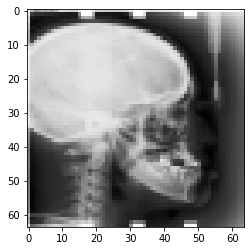

(150, 64, 64, 3)


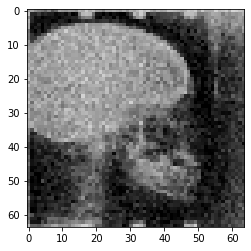

In [18]:
test_gaussian(x_train,x_test,0,0.07)

In [19]:
def test_sp(x_train):
    
    noise_img = make_sp_noise(x_train,0.05)
    
    print(noise_img.shape)
    
    plt.imshow(noise_img[0])
    
    plt.show()
    
    
   

(150, 64, 64, 3)


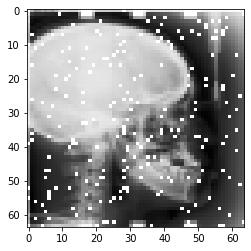

In [20]:
test_sp(x_train)

In [21]:
def test_poisson(img_mat):
    
#     #poisson
    
#     vals = len(np.unique(img_mat))
    
#     print(vals)
    
#     vals = len(np.unique(img_mat))
#     vals = 2 ** np.ceil(np.log2(vals))
#     noisy = np.random.poisson(img_mat * vals) / float(vals)
#     print(noisy.shape)

    noisy = make_poisson_noise(img_mat)
    
    
    plt.imshow(img_mat[0])
    plt.show()
    
    plt.imshow(noisy[0])
    
    plt.show()
    

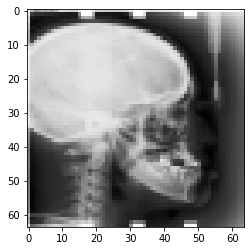

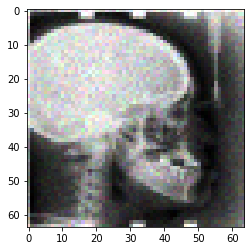

In [22]:
test_poisson(x_train)

### Creates encoder, decoder network

In [23]:
def net(input_shape,kernel_size, encoder_len, decoder_len):
    
    '''''
    Creates convolutional autoencoder 
    
    Arguments:
    
    input_shape -- image shape
    
    kernel_size -- number of channels in image
    
    encoder_len -- number of layers in encoder
    
    decoder_len -- number of layers in decoder
    
    Returns:
    
    autoencoder -- instance of the model
    
    
    '''''
    
    inputs = Input(shape=input_shape, name='encoder_inputs')
    
    x = inputs
    
    for i in range(encoder_len):
    
        x = Conv2D(filters=64,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)

        x = MaxPooling2D()(x)
    
    for j in range(decoder_len):
    
        x = Conv2D(filters=64,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)

        x = UpSampling2D()(x)
    
    x = Conv2D(filters=3,
                   kernel_size=kernel_size,
                   strides=1,
                   activation='sigmoid',
                   padding='same')(x)
    
    autoencoder = Model(inputs,x)
    
    plot_model(autoencoder, to_file='autoencoder_plot.png' , show_shapes=True, show_layer_names=True)
    
    autoencoder.summary()
    
    return autoencoder
    

In [24]:
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
kernel_size = 3
encoder_len = 2
decoder_len = 2
autoencoder_img = net(input_shape, kernel_size, encoder_len, decoder_len)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
______________________________________________

In [25]:
def train_autoencoder(batch_size,autoencoder,x_train_noisy, x_test_noisy, x_train, x_test):
    
    '''''
    Train autoencoder model and plot history of train and test losses
    
    Arguments:
    
    batch_size -- batch size
    
    autoencoder -- instance of the model
    
    x_train_noisy -- denoised x_train
    
    x_test_noisy -- denoised x_test
    
    x_train -- original x_train
    
    x_test -- original x_test
    
    Returns:
    
    x_decoded -- decoded image
    
    autoencoder -- trained model
    
    '''''

    autoencoder.compile(loss='mse', optimizer='adam')

    # Train the autoencoder
    history = autoencoder.fit(x_train_noisy,
                    x_train,
                    validation_data=(x_test_noisy, x_test),
                    epochs=30,
                    batch_size=batch_size)

    # Predict the Autoencoder output from corrupted test images
    
        # list all data in history
    print(history.history.keys())
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    x_decoded = autoencoder.predict(x_test_noisy)
    
    return x_decoded, autoencoder

Train on 150 samples, validate on 150 samples
Epoch 1/30
150/150 [==============================] - 1s 8ms/sample - loss: 0.0661 - val_loss: 0.0439
Epoch 2/30
150/150 [==============================] - 1s 6ms/sample - loss: 0.0270 - val_loss: 0.0269
Epoch 3/30
150/150 [==============================] - 1s 6ms/sample - loss: 0.0186 - val_loss: 0.0163
Epoch 4/30
150/150 [==============================] - 1s 6ms/sample - loss: 0.0139 - val_loss: 0.0120
Epoch 5/30
150/150 [==============================] - 1s 6ms/sample - loss: 0.0115 - val_loss: 0.0104
Epoch 6/30
150/150 [==============================] - 1s 5ms/sample - loss: 0.0099 - val_loss: 0.0096
Epoch 7/30
150/150 [==============================] - 1s 6ms/sample - loss: 0.0088 - val_loss: 0.0081
Epoch 8/30
150/150 [==============================] - 1s 6ms/sample - loss: 0.0077 - val_loss: 0.0072
Epoch 9/30
150/150 [==============================] - 1s 7ms/sample - loss: 0.0070 - val_loss: 0.0065
Epoch 10/30
150/150 [===============

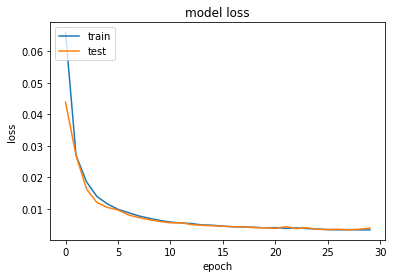

In [26]:
batch_size = 16
x_decoded, autoencoder_model = train_autoencoder(batch_size,autoencoder_img,x_train_noisy_gauss, x_test_noisy_gauss, x_train, x_test)

In [27]:
def read_img_all(imgs, x_test, x_test_noisy, x_decoded):
    
    '''''
    Plot 10 test examples of original, denoising and denoised images
    
    First row: Original images
    
    Second row: Images with noise
    
    Third row: Filtered images
    
    
    '''''
    
    fig2, ax_array = plt.subplots(3, 10, figsize=(14,8),sharex=True)
    
    ax1 = ax_array[0]
    ax2 = ax_array[1]
    ax3 = ax_array[2]
    
    for j in range(len(ax1)):

        ax1[j].imshow(x_test[j].squeeze(),cmap='gray')

        ax2[j].imshow(x_test_noisy[j].squeeze(),cmap='gray')

        ax3[j].imshow(x_decoded[j].squeeze(),cmap='gray')


    plt.show()


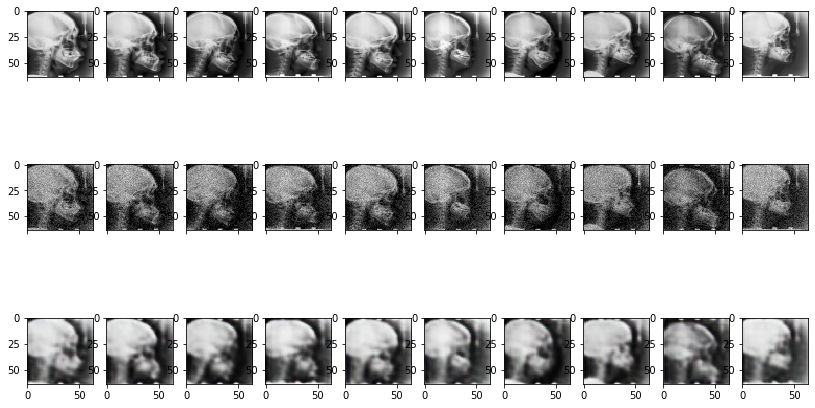

In [29]:
read_img_all(10, X_test, x_test_noisy_gauss, x_decoded)